In [1]:
import copy
import os.path as osp
import csv

import utils as ut

import torch.nn as nn
import torch.nn.functional as F
from torch.nn import GRU, Linear, ReLU, Sequential

import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, Set2Set
from torch_geometric.utils import remove_self_loops
import torch_geometric

from detanet_model import *

In [2]:

# File path (replace with the actual file path)
csv_path = "/media/maria/work_space/capsule-3259363/data/HarvardOPV_40.csv" #data/HarvardOPV_40.csv"

# Open the CSV file and process it
dataset = []
with open(csv_path, newline='', encoding='utf-8') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter=',')
    
    # Read the header to identify column indices
    header = next(csv_reader)
    smiles_idx = header.index("smiles")
    homo_idx = header.index("homo")
    lumo_idx = header.index("lumo")
    
    # Read each row
    for row in csv_reader:
        smiles = row[smiles_idx]
        homo = torch.tensor([float(row[homo_idx])], dtype=torch.float) * 27 # Convert to eV
        lumo = torch.tensor([float(row[lumo_idx])], dtype=torch.float32) * 27 # Convert to eV

        # Convert SMILES to molecular graph
        graph_data = ut.smiles_to_graph(smiles)
        if graph_data is None:
            continue  # Skip invalid molecules
        
        z, pos = graph_data
        
        # Create a PyTorch Geometric Data object
        data_entry = Data(
            pos=pos.to(torch.float32),    # Atomic positions
            z=torch.LongTensor(z),        # Atomic numbers
            y=torch.tensor([homo, lumo], dtype=torch.float32),  # Polarizability tensor (target)
        )
        
        dataset.append(data_entry)

[13:30:45] UFFTYPER: Unrecognized atom type: Se2+2 (4)
[13:30:45] UFFTYPER: Unrecognized atom type: Se2+2 (4)


In [3]:
train_datasets=[]
val_datasets=[]
for i in range(len(dataset)):
    if i%3==0:
        val_datasets.append(dataset[i])
    else:
        train_datasets.append(dataset[i])
        
len(train_datasets),len(val_datasets)

(108, 54)

In [4]:
'''Using torch_Geometric.dataloader.DataLoader Converts a dataset into a batch of 64 molecules of training data.'''
batches=16
trainloader=DataLoader(train_datasets,batch_size=batches,shuffle=True)
valloader=DataLoader(val_datasets,batch_size=batches,shuffle=True)

In [5]:
from detanet_model import DetaNet

# load model

device=torch.device('cpu')

trained_model=DetaNet(num_features=128,
                 act='swish',
                 maxl=3,
                 num_block=3,
                 radial_type='trainable_bessel',
                 num_radial=32,
                 attention_head=8,
                 rc=5.0,
                 dropout=0.0,
                 use_cutoff=False,
                 max_atomic_number=34,
                 atom_ref=None,
                 scale=None,
                 scalar_outsize=2,
                 irreps_out=None,
                 summation=False,
                 norm=False,
                 out_type='scalar',
                 grad_type=None ,
                 device=torch.device(device))
state_dict = torch.load("/media/maria/work_space/capsule-3259363/code/trained_param/homo_lumo.pth")
trained_model.load_state_dict(state_dict=state_dict)

/tmp/ipykernel_54391/588091135.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/media/maria/work_space/capsule-3259363/code/trained_param/homo_

<All keys matched successfully>

In [6]:
from torch_geometric.nn import global_mean_pool

'''Next, define the trainer and the parameters used for training.'''
class Trainer:
    def __init__(self,model,train_loader,val_loader=None,loss_function=l2loss,device=torch.device(device),
                 optimizer='Adam_amsgrad',lr=5e-4,weight_decay=0):
        self.opt_type=optimizer
        self.device=device
        self.model=model
        self.train_data=train_loader
        self.val_data=val_loader
        self.device=device
        self.opts={'AdamW':torch.optim.AdamW(self.model.parameters(),lr=lr,amsgrad=False,weight_decay=weight_decay),
              'AdamW_amsgrad':torch.optim.AdamW(self.model.parameters(),lr=lr,amsgrad=True,weight_decay=weight_decay),
              'Adam':torch.optim.Adam(self.model.parameters(),lr=lr,amsgrad=False,weight_decay=weight_decay),
              'Adam_amsgrad':torch.optim.Adam(self.model.parameters(),lr=lr,amsgrad=True,weight_decay=weight_decay),
              'Adadelta':torch.optim.Adadelta(self.model.parameters(),lr=lr,weight_decay=weight_decay),
              'RMSprop':torch.optim.RMSprop(self.model.parameters(),lr=lr,weight_decay=weight_decay),
              'SGD':torch.optim.SGD(self.model.parameters(),lr=lr,weight_decay=weight_decay)
        }
        self.optimizer=self.opts[self.opt_type]
        
        self.loss_function=loss_function
        self.step=-1
    def train(self,num_train,targ,stop_loss=1e-8, val_per_train=50, print_per_epoch=10):
        self.model.train()
        len_train=len(self.train_data)
        for i in range(num_train):
            val_datas=iter(self.val_data)
            for j,batch in enumerate(self.train_data):
                self.step=self.step+1
                torch.cuda.empty_cache()
                self.optimizer.zero_grad()
                out = self.model(pos=batch.pos.to(self.device), z=batch.z.to(self.device),
                                     batch=batch.batch.to(self.device))
                #print("out", out.shape)
                graph_out = global_mean_pool(out, batch.batch)  # Shape: [batch_size, d]

                # print("graph_out", graph_out.shape)

                target = batch[targ].to(self.device)

                #print("target" , target.shape)
                loss = self.loss_function(graph_out.reshape(target.shape),target)
                loss.backward()
                self.optimizer.step()
                if (self.step%val_per_train==0) and (self.val_data is not None):
                    val_batch = next(val_datas)
                    val_target=val_batch[targ].to(self.device).reshape(-1)

                    val_out = self.model(pos=val_batch.pos.to(self.device), z=val_batch.z.to(self.device),
                    batch=val_batch.batch.to(self.device))
                    # Aggregate node-level outputs to graph-level outputs
                    val_graph_out = global_mean_pool(val_out, val_batch.batch)  # Shape: [val_batch_size, d]

                    # Ensure the shapes match
                    val_loss = self.loss_function(val_graph_out.reshape(val_target.shape), val_target).item()
                    val_mae = l1loss(val_graph_out.reshape(val_target.shape), val_target).item()
                    val_R2 = R2(val_graph_out.reshape(val_target.shape), val_target).item()

                    if self.step % print_per_epoch==0:
                        print('Epoch[{}/{}],loss:{:.8f},val_loss:{:.8f},val_mae:{:.8f},val_R2:{:.8f}'
                              .format(self.step,num_train*len_train,loss.item(),val_loss,val_mae,val_R2))

                    assert (loss > stop_loss) or (val_loss > stop_loss),'Training and prediction Loss is less' \
                                                                        ' than cut-off Loss, so training stops'
                elif (self.step % print_per_epoch == 0) and (self.step%val_per_train!=0):
                    print('Epoch[{}/{}],loss:{:.8f}'.format(self.step,num_train*len_train, loss.item()))
                    
    def load_state_and_optimizer(self,state_path=None,optimizer_path=None):
        if state_path is not None:
            state_dict=torch.load(state_path)
            self.model.load_state_dict(state_dict)
        if optimizer_path is not None:
            self.optimizer=torch.load(optimizer_path)

    def save_param(self,path):
        torch.save(self.model.state_dict(),path)

    def save_model(self,path):
        torch.save(self.model, path)

    def save_opt(self,path):
        torch.save(self.optimizer,path)

    def params(self):
        return self.model.state_dict()
    

In [7]:
'''Then, modify the data type and device type'''
device=torch.device('cpu')
dtype=torch.float32
trained_model=trained_model.to(dtype)
trained_model=trained_model.to(device)

In [8]:
trainer=Trainer(trained_model,train_loader=trainloader,val_loader=valloader,loss_function=l2loss,lr=5e-4,weight_decay=0,optimizer='AdamW')

In [10]:
trainer.train(num_train=25,targ='y')

Epoch[10/175],loss:0.18868794
Epoch[20/175],loss:0.12911098
Epoch[30/175],loss:0.22409816
Epoch[40/175],loss:0.26111668
Epoch[50/175],loss:0.08349410,val_loss:0.03655362,val_mae:0.15321979,val_R2:0.99702454
Epoch[60/175],loss:0.12767567
Epoch[70/175],loss:0.17095844
Epoch[80/175],loss:0.02890757
Epoch[90/175],loss:0.11837145
Epoch[100/175],loss:0.15091786,val_loss:0.15188374,val_mae:0.28121731,val_R2:0.98757005
Epoch[110/175],loss:0.08546857
Epoch[120/175],loss:0.07502706
Epoch[130/175],loss:0.07893878
Epoch[140/175],loss:0.06884433
Epoch[150/175],loss:0.05192028,val_loss:0.13506334,val_mae:0.26233944,val_R2:0.98975587
Epoch[160/175],loss:0.05918762
Epoch[170/175],loss:0.05537746
Epoch[180/175],loss:0.05271498


In [11]:
torch.save(trained_model.state_dict(),'trained_param/homo_lumo_finetuned.pth')

In [12]:
eval_loader = DataLoader(val_datasets, batch_size=1, shuffle=False)

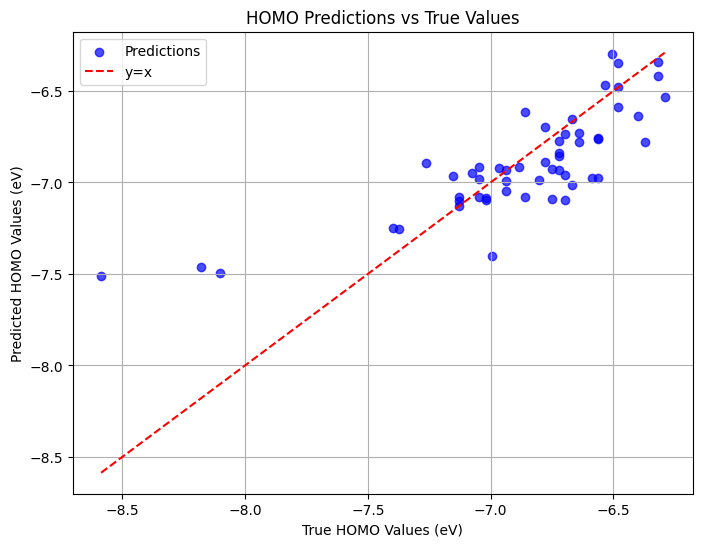

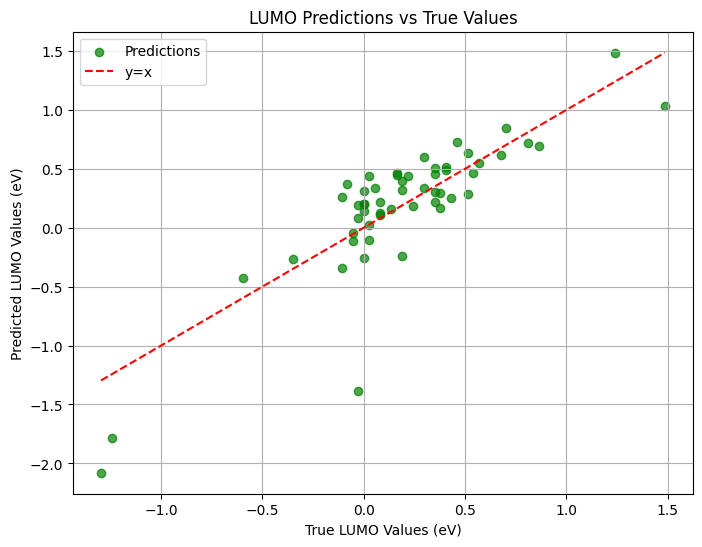

In [13]:

# Create result graphs
import matplotlib.pyplot as plt
import torch
from torch_geometric.nn import global_mean_pool

# Get predictions
predictions = []
true_values = []

for batch in eval_loader:
    true_values.append(batch.y.unsqueeze(0))  # Ensure correct shape
    with torch.no_grad():
        val_out = trained_model(pos=batch.pos.to(device), z=batch.z.to(device),
                                batch=batch.batch.to(device))
        val_graph_out = global_mean_pool(val_out, batch.batch)  # Shape: [batch_size, d]
        predictions.append(val_graph_out)

# Convert lists of tensors to a single tensor
true_values = torch.cat(true_values, dim=0).cpu()  # Now shape [num_samples, 2]
predictions = torch.cat(predictions, dim=0).cpu()  # Now shape [num_samples, 2]

# Separate HOMO and LUMO values
true_homo_values = true_values[:, 0]  
true_lumo_values = true_values[:, 1]  
predictions_homo_values = predictions[:, 0] 
predictions_lumo_values = predictions[:, 1] 

# 🔵 Plot HOMO results
plt.figure(figsize=(8, 6))
plt.scatter(true_homo_values, predictions_homo_values, c='blue', alpha=0.7, label='Predictions')
plt.plot([min(true_homo_values), max(true_homo_values)], [min(true_homo_values), max(true_homo_values)], color='red', linestyle='--', label='y=x')
plt.xlabel('True HOMO Values (eV)')
plt.ylabel('Predicted HOMO Values (eV)')
plt.title('HOMO Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.savefig("HOMO_QM9.png")

# 🟢 Plot LUMO results
plt.figure(figsize=(8, 6))
plt.scatter(true_lumo_values, predictions_lumo_values, c='green', alpha=0.7, label='Predictions')
plt.plot([min(true_lumo_values), max(true_lumo_values)], [min(true_lumo_values), max(true_lumo_values)], color='red', linestyle='--', label='y=x')
plt.xlabel('True LUMO Values (eV)')
plt.ylabel('Predicted LUMO Values (eV)')
plt.title('LUMO Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.savefig("LUMO_QM9.png")
   